In [14]:
import gym
import gymnasium as gym
from gymnasium import Env, spaces
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.express as px
import random
import networkx as nx
import matplotlib.patches as mpatches
import torch as th






In [15]:
num_drones = 3
limite_y = 80
limite_x = 100
alcance_comunicacao_jammer = 25
alcance_comunicacao_nos = 5000
B_Hz = 2.4e9
posicoes = np.array([[18, 52], [33, 20], [44, 15]])
posicao_jammer = np.array([40, 80])

In [16]:


# Definir a subgrade dentro da área maior
area_size = (100, 100)
subgrade_start = (25, 15)  # Ponto inicial da subgrade (x, y)
subgrade_size = (50, 50)   # Tamanho da subgrade (largura, altura)
resolution = 5             # Resolução da subgrade (distância entre pontos)

# Gerar os pontos discretizados na subgrade
x_points = np.arange(subgrade_start[0], subgrade_start[0] + subgrade_size[0] + 1, resolution)
y_points = np.arange(subgrade_start[1], subgrade_start[1] + subgrade_size[1] + 1, resolution)
grid_points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1, 2)


FUNÇÕES

In [17]:
# Função para calcular a distância entre duas posições
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Função para encontrar vizinhos dentro do alcance de comunicação
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

# Função para verificar quais drones são afetados pelo jammer
def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

# Gera direções aleatórias para as antenas
# direcoes_antena = np.random.uniform(0, 360, size=num_drones)
# direcoes_antena = [278, 102, 235, 312, 182, 242]
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)
# Comprimento das setas para indicar a direção das antenas
comprimento_seta = 5
# Função para calcular o ângulo entre dois nós em relação à direção da antena
def angulo_entre_nos(pos1, direcao_antena, pos2):
    # Vetor entre os dois nós
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    
    # Direção do vetor em graus
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    
    # Diferença entre a direção do vetor e a direção da antena
    angulo = direcao_vetor_deg - direcao_antena
    
    # Ajustar para o intervalo de 0 a 360 graus
    angulo = angulo % 360  # Usa módulo para garantir que o valor esteja entre 0 e 360
    angulo_arredondado = round(angulo)
    
    return angulo_arredondado

# Posições dos drones
# posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

# Direções aleatórias das antenas
direcoes_antena = np.random.uniform(0, 360, size=posicoes.shape[0])

# Matriz para armazenar os ângulos
angulos_matriz = np.zeros((posicoes.shape[0], posicoes.shape[0]))

# Calcular os ângulos para todas as combinações de drones
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            angulos_matriz[i, j] = angulo_entre_nos(posicoes[i], direcoes_antena[i], posicoes[j])

# Apresentar os ângulos entre drones sem valores negativos
for i in range(posicoes.shape[0]):
    print(f"Drones que o drone {i} 'vê' com um ângulo:")
    for j in range(posicoes.shape[0]):
        if i != j:
            angulo_arredondado = int(round(angulos_matriz[i, j]))  # Arredondar para unidade
            print(f"  Com o drone {j}: {angulo_arredondado} graus")

Drones que o drone 0 'vê' com um ângulo:
  Com o drone 1: 325 graus
  Com o drone 2: 335 graus
Drones que o drone 1 'vê' com um ângulo:
  Com o drone 0: 87 graus
  Com o drone 2: 308 graus
Drones que o drone 2 'vê' com um ângulo:
  Com o drone 0: 211 graus
  Com o drone 1: 242 graus


In [18]:


Ptx_dBm = 20 
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2
sigma = 0
c=3e8
lambda_m=c/f
L0=30
potencia_jammer_dBm =100

# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')


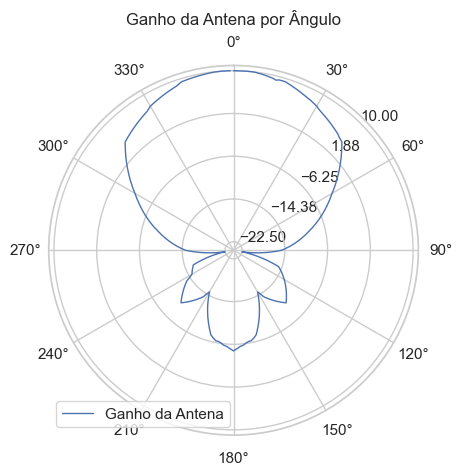

In [19]:
angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [20]:
def busca_ganhos( angulo):
    # Arredondar para o ângulo inteiro mais próximo
    angulo_ajustado = int(round(angulo))
    
    if angulo_ajustado==360:
        angulo_ajustado=0
    
    # Encontrar o ganho correspondente ao ângulo ajustado
    ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    
    return ganho



# Função para calcular os ganhos de transmissão e recepção
def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    # Obter posições e direções
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]
    
    # Calcular o ângulo entre os dois nós em relação à direção da antena
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)
    # print('Angulo receção:',angulo_rececao)
    # print('Angulo tranmissão:',angulo_transmissao)

    # Obter os ganhos para transmissão e recepção
    ganho_transmissao = busca_ganhos( angulo_transmissao)
    ganho_rececao = busca_ganhos( angulo_rececao)
    
    return ganho_transmissao, ganho_rececao

# ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, 0, 1, ganhos_df)



def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d,f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    # L = (4 * np.pi * d / lambda_m)**2
    # Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - 10 * np.log10(L)
    # return Prx_dBm
    # Calcular a perda de percurso
    if d > 0:
        L = L0 + 10 * gamma * np.log10(d / d0) + np.random.normal(0, sigma)
    else:
        L = L0  # Se a distância for zero, assume-se a perda na distância de referência

    # Calcular a potência do sinal recebido
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - L

    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    # Calcular a distância entre o drone e o jammer
    d = distancia(pos_drone, pos_jammer)
    
    # Calcular o ângulo entre o drone e o jammer
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    
    # Obter o ganho do drone em direção ao jammer
    ganho_drone_para_jammer = busca_ganhos( angulo_entre_drone_e_jammer)
    
    # Calcular a potência do ruído recebido usando a equação de Friis
    L = (4 * np.pi * d / lambda_m) ** 2  # Perda de propagação
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    """
    Calcula a capacidade do canal em bits por segundo usando a fórmula de Shannon-Hartley.
    """
    # Converter potência em dBm para Watts
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000  # Potência do sinal em Watts
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000  # Potência do ruído em Watts
    
    # Calcular a razão sinal-ruído (SNR)
    snr = potencia_sinal_W / potencia_ruido_W
    
    # Calcular a capacidade do canal em bits por segundo (bps)
    capacidade = B_Hz * np.log2(1 + snr)
    
    return capacidade/1e3

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            # Calcular a distância entre os dois drones
            d = distancia(posicoes[i], posicoes[j])
            
            # Calcular os ganhos de transmissão e recepção
            ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, i, j, ganhos_df)
            # print(posicoes)
            print('Ganhos Rx,Tx:',ganho_transmissao, ganho_rececao)
            # Calcular a potência do sinal recebido usando a equação de Friis
            potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
            potencia_ruido = calcula_potencia_jammer(posicoes[j], direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
            capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
            # Imprimir a combinação de nós e a potência do sinal recebido
            print(f"  Potencia recebida do drone {i} para o drone {j}: {potencia_recebida:.2f} dBm")
            print(f"  Ruido recebido no drone {j} e do jammer: {potencia_ruido:.2f} dBm")
            print(f"  Capacidade do canal {i} para {j}: {capacidade_canal:.2f} bps")

Ganhos Rx,Tx: 6.5 -13.8
  Potencia recebida do drone 0 para o drone 1: -48.27 dBm
  Ruido recebido no drone 1 e do jammer: 24.33 dBm
  Capacidade do canal 0 para 1: 0.19 bps
Ganhos Rx,Tx: 8.15 -14.6
  Potencia recebida do drone 0 para o drone 2: -49.56 dBm
  Ruido recebido no drone 2 e do jammer: 18.68 dBm
  Capacidade do canal 0 para 2: 0.52 bps
Ganhos Rx,Tx: -13.8 6.5
  Potencia recebida do drone 1 para o drone 0: -48.27 dBm
  Ruido recebido no drone 0 e do jammer: 17.12 dBm
  Capacidade do canal 1 para 0: 1.00 bps
Ganhos Rx,Tx: 1.5 -15.2
  Potencia recebida do drone 1 para o drone 2: -45.34 dBm
  Ruido recebido no drone 2 e do jammer: 18.68 dBm
  Capacidade do canal 1 para 2: 1.37 bps
Ganhos Rx,Tx: -14.6 8.15
  Potencia recebida do drone 2 para o drone 0: -49.56 dBm
  Ruido recebido no drone 0 e do jammer: 17.12 dBm
  Capacidade do canal 2 para 0: 0.74 bps
Ganhos Rx,Tx: -15.2 1.5
  Potencia recebida do drone 2 para o drone 1: -45.34 dBm
  Ruido recebido no drone 1 e do jammer: 24.33

DRL

In [33]:
class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100), render_mode=None):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.render_mode = render_mode
        self.posicoes = posicoes.copy()
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}
        self.max_steps = 100  # Número máximo de passos por episódio
        self.current_step = 0  # Contador de passos

        # Define o espaço de ação: direções das antenas + deslocamentos x e y
        self.action_space = spaces.Box(low=np.array([0]*num_uavs + [-10]*num_uavs + [-10]*num_uavs), 
                                       high=np.array([360]*num_uavs + [10]*num_uavs + [10]*num_uavs), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=360, shape=(num_uavs,), dtype=np.float32)

        self.direcoes_antena = np.random.uniform(0, 360, size=num_uavs)
        self.capacidades = []  # Inicializa a lista de capacidades para normalização

        # Definir a subgrade
        self.x_points = np.arange(subgrade_start[0], subgrade_start[0] + subgrade_size[0] + 1, resolution)
        self.y_points = np.arange(subgrade_start[1], subgrade_start[1] + subgrade_size[1] + 1, resolution)
    
    def step(self, action):
        self.current_step += 1

        direcoes_antena = action[:self.num_uavs]
        movimentos_x = action[self.num_uavs:2*self.num_uavs]
        movimentos_y = action[2*self.num_uavs:]

        self.direcoes_antena = np.array(direcoes_antena, dtype=np.float32)

        new_positions = []

        for i in range(self.num_uavs):
            nova_pos_x = self.posicoes[i][0] + movimentos_x[i]
            nova_pos_y = self.posicoes[i][1] + movimentos_y[i]
            nova_pos_x = min(max(nova_pos_x, subgrade_start[0]), subgrade_start[0] + subgrade_size[0])
            nova_pos_y = min(max(nova_pos_y, subgrade_start[1]), subgrade_start[1] + subgrade_size[1])

            # Ajustar as posições para os pontos discretos mais próximos
            nova_pos_x = self.x_points[np.argmin(np.abs(self.x_points - nova_pos_x))]
            nova_pos_y = self.y_points[np.argmin(np.abs(self.y_points - nova_pos_y))]
            
            new_positions.append([nova_pos_x, nova_pos_y])

        new_positions = np.array(new_positions)

        # Verificar se duas ou mais posições são iguais e ajustá-las
        unique_positions, counts = np.unique(new_positions, axis=0, return_counts=True)
        while np.any(counts > 1):
            duplicates = unique_positions[counts > 1]
            for dup in duplicates:
                indices = np.where((new_positions == dup).all(axis=1))[0]
                for index in indices[1:]:
                    # Tentar mover para uma posição adjacente não ocupada
                    for dx, dy in [(-resolution, 0), (resolution, 0), (0, -resolution), (0, resolution)]:
                        new_pos = new_positions[index] + np.array([dx, dy])
                        if (new_pos >= subgrade_start).all() and (new_pos <= (subgrade_start[0] + subgrade_size[0], subgrade_start[1] + subgrade_size[1])).all():
                            if not any((new_positions == new_pos).all(axis=1)):
                                new_positions[index] = new_pos
                                break
            unique_positions, counts = np.unique(new_positions, axis=0, return_counts=True)

        self.posicoes = new_positions

        capacidades_por_link = []

        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    d = distancia(self.posicoes[i], self.posicoes[j])
                    ganho_transmissao, ganho_rececao = calcula_ganhos(self.posicoes, self.direcoes_antena, i, j, ganhos_df)
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(self.posicoes[j], self.direcoes_antena[j], self.posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal = calcula_capacidade(potencia_recebida, potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)

        capacidade_media = np.mean(capacidades_por_link)
        capacidade_minima = np.min(capacidades_por_link)

        self.capacidades.extend(capacidades_por_link)
        if len(self.capacidades) > 1000:
            self.capacidades = self.capacidades[-1000:]

        min_capacidade = np.min(self.capacidades)
        max_capacidade = np.max(self.capacidades)

        G = nx.Graph()
        num_drones = self.posicoes.shape[0]
        capacidade_matriz = np.zeros((self.num_uavs, self.num_uavs))
        link_index = 0

        for i in range(self.num_uavs):
            for j in range(self.num_uavs):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        for i in range(num_drones):
            for j in range(i + 1, num_drones):
                capacidade = capacidade_matriz[i, j]
                G.add_edge(i, j, weight=1.0 / capacidade)

        bottlenecks = {}
        for i in range(num_drones):
            for j in range(num_drones):
                if i != j:
                    try:
                        caminho = nx.dijkstra_path(G, source=i, target=j, weight='weight')
                        menor_capacidade = float('inf')
                        for k in range(len(caminho) - 1):
                            cap_atual = capacidade_matriz[caminho[k], caminho[k+1]]
                            if cap_atual < menor_capacidade:
                                menor_capacidade = cap_atual
                        bottlenecks[(i, j)] = (caminho, menor_capacidade)
                    except nx.NetworkXNoPath:
                        print(f"Não há caminho do nó {i} para o nó {j}")

        capacidade_bottleneck_media = np.mean([bottleneck for caminho, bottleneck in bottlenecks.values()])
        capacidade_bottleneck_minima = np.min([bottleneck for caminho, bottleneck in bottlenecks.values()])

        distancia_jammer = np.mean([distancia(pos, self.posicao_jammer) for pos in self.posicoes])
        penalidade_distancia_jammer = -(distancia_jammer ** 2)  # Ajustado para escala apropriada

        distancias_entre_drones = [distancia(self.posicoes[i], self.posicoes[j]) for i in range(num_drones) for j in range(i+1, num_drones)]
        distancia_minima_entre_drones = np.min(distancias_entre_drones)
        penalidade_proximidade_drones = (max(0, (30 - distancia_minima_entre_drones) ** 2))  # Ajustado para escala apropriada

        recompensa = capacidade_media * capacidade_bottleneck_minima - (0 * penalidade_distancia_jammer + 0 * penalidade_proximidade_drones)

        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        capacidade_media = round(capacidade_media, 3)

        info = {
            'Recompensa': recompensa,
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz,
            'Capacidade mínima [Kbps]': capacidade_minima,
            'Capacidade bottleneck média': capacidade_bottleneck_media,
            'Capacidade bottleneck mínima': capacidade_bottleneck_minima,
            'Penalidade distância ao jammer': penalidade_distancia_jammer,
            'Penalidade proximidade entre drones': penalidade_proximidade_drones
        }



        done = self.current_step >= self.max_steps
        truncated=False
        return np.array(self.direcoes_antena, dtype=np.float32), recompensa, done,truncated, info


    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))
        # Desenhar a subgrade e o limite da área
        subgrade_start = (25, 15)  # Ponto inicial da subgrade (x, y)
        subgrade_size = (50, 50)  # Tamanho da subgrade (largura, altura)
        resolution = 5  # Resolução da subgrade (distância entre pontos)

        # Desenhar o limite da área dos drones
        rect = plt.Rectangle(subgrade_start, subgrade_size[0], subgrade_size[1], linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

        # Desenhar linhas verticais da subgrade dentro do limite da área
        for x in np.arange(subgrade_start[0], subgrade_start[0] + subgrade_size[0] + resolution, resolution):
            ax.axvline(x, color='blue', linestyle='--', linewidth=0.5)

        # Desenhar linhas horizontais da subgrade dentro do limite da área
        for y in np.arange(subgrade_start[1], subgrade_start[1] + subgrade_size[1] + resolution, resolution):
            ax.axhline(y, color='blue', linestyle='--', linewidth=0.5)

        # Desenhar os drones
        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        # Desenhar as direções das antenas
        comprimento_seta = 5
        for i, direcao in enumerate(self.direcoes_antena):
            direcao_rad = np.radians(direcao)
            dx = comprimento_seta * np.cos(direcao_rad)
            dy = comprimento_seta * np.sin(direcao_rad)

            ax.arrow(
                self.posicoes[i][0], self.posicoes[i][1],
                dx, dy,
                head_width=2, head_length=2, fc='b', ec='b'
            )

        # Desenhar o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        ax.set_yticks(np.arange(0, self.area_size[1] + 1, 20))  # Configurar a escala vertical de 20 em 20
        plt.title('Direções das Antenas UAV')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

        plt.show()


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_step = 0
        # self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        self.posicoes = posicoes.copy()
        # Garantir que as posições iniciais também sejam ajustadas para os pontos discretos mais próximos
        # for i in range(self.num_uavs):
        #     self.posicoes[i][0] = self.x_points[np.argmin(np.abs(self.x_points - self.posicoes[i][0]))]
        #     self.posicoes[i][1] = self.y_points[np.argmin(np.abs(self.y_points - self.posicoes[i][1]))]
        obs = np.array(self.direcoes_antena, dtype=np.float32)
        return obs, {}

TESTAR O AMBIENTE

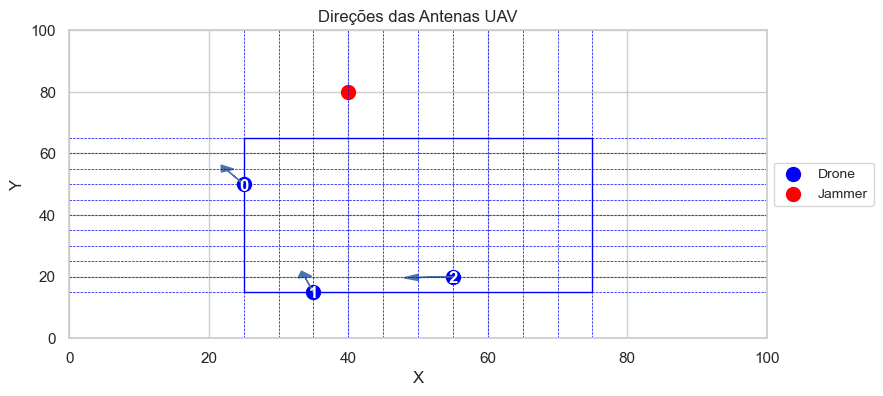

Direções Estabelecidas:
 [117.39135 104.08476 183.08267]

Recompensa:
 0.12714019034438637

Capacidade Média [Kbps]: 2.314

Capacidade Minima [Kbps]: 0.05493707013266253

Capacidade por Link [Kbps]: [0.295, 2.406, 0.579, 10.429, 0.055, 0.121]

Matriz de Capacidades [Kbps]: 	0.00 0.30 2.41
	0.58 0.00 10.43
	0.05 0.12 0.00


In [34]:
env = UAVCommunicationEnv()

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Escolha uma ação aleatoriamente
    state, reward,terminated, truncated,info = env.step(action)
    env.render()  # Chame render a cada passo para visualizar
    
    print('Direções Estabelecidas:\n', state)
    print("\nRecompensa:\n", reward)
    if 'Capacidade média [Kbps]' in info:
        print("\nCapacidade Média [Kbps]:", info['Capacidade média [Kbps]'])
    if 'Capacidade média [Kbps]' in info:
        print("\nCapacidade Minima [Kbps]:", info['Capacidade mínima [Kbps]'])
    if 'Capacidades_por_link [Kbps]' in info:
        print("\nCapacidade por Link [Kbps]:", info['Capacidades_por_link [Kbps]'])
    if 'Matriz de Capacidades [Kbps]' in info:
        # capacidade_matriz=info['Matriz de Capacidades [Kbps]']
        print("\nMatriz de Capacidades [Kbps]:", '\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in info['Matriz de Capacidades [Kbps]']]))
    else:
        print("Chave 'Matriz de Capacidades [Kbps]' não encontrada em info.")
    done = True

PPO(Proximal Policy Optimization) ALGORITHM

Explora politicas em vez de atribuir valores aos pares estado-ação

Using cpu device
 -------------------------Treinar o modelo----------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 1.24e+03 |
| time/              |          |
|    fps             | 259      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
 -------------------------Avaliar o modelo----------------------------
Recompensa média: 1624.5972040499996 ± 2105.286277909703
 -------------------------Testar o modelo----------------------------


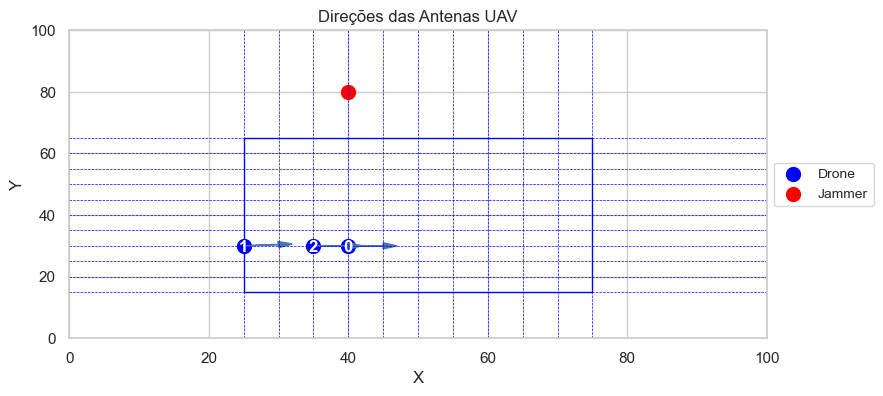


Recompensa: [128488.805]

Direções das Antenas: [0.       4.893465 0.      ]
Best positions:
 [[40 30]
 [25 30]
 [35 30]]


In [35]:
# Inicializar o ambiente com render_mode
env = UAVCommunicationEnv()

# Criar um ambiente monitorado para registro de métricas
env = Monitor(env)

# Criar um DummyVecEnv para compatibilidade com o Stable-Baselines3
env = DummyVecEnv([lambda: env])

# Definir o modelo PPO
model = PPO("MlpPolicy", env, verbose=1, n_steps=2048, batch_size=128, learning_rate=3e-1)

print(' -------------------------Treinar o modelo----------------------------')
model.learn(total_timesteps=1000)

# Salvar o modelo treinado
# model.save("ppo_uav_communication")

# Carregar o modelo treinado (se necessário)
# model = PPO.load("ppo_uav_communication")

print(' -------------------------Avaliar o modelo----------------------------')
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"Recompensa média: {mean_reward} ± {std_reward}")


print(' -------------------------Testar o modelo----------------------------')

# Testar o modelo treinado e encontrar o melhor cenário
best_reward = -float('inf')
best_obs = None
best_posicoes = None
best_direcoes_antena = None
best_info = None

# Acessar o ambiente subjacente
real_env = env.envs[0].unwrapped

for _ in range(100):
    # print(_)
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if reward > best_reward:
            best_reward = reward
            best_obs = obs
            best_posicoes = real_env.posicoes.copy()
            best_direcoes_antena = real_env.direcoes_antena.copy()
            # print('Direções:',best_direcoes_antena)
            best_info = info

# Renderizar o melhor cenário
# real_env.reset()
real_env.posicoes = best_posicoes.copy()
real_env.direcoes_antena = best_direcoes_antena.copy()

real_env.render()



print(f'\nRecompensa: {best_reward}')
print(f'\nDireções das Antenas: {best_direcoes_antena}')
print("Best positions:\n", best_posicoes)


# Imprimir os valores desejados da best_info
if best_info:
    if 'Capacidade média [Kbps]' in best_info:
        print(f"Capacidade Média [Kbps]: {best_info['Capacidade média [Kbps]']}")
    if 'Capacidade bottleneck mínima' in best_info:
        print(f"Capacidade Bottleneck Mínima: {best_info['Capacidade bottleneck mínima']}")
else:
    print("best_info is None or empty.")